Imports

In [29]:
import folium
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.signal import find_peaks
from geopy.distance import distance

In [2]:
%matplotlib inline

Display Settings

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

Load Data

In [4]:
position_df = pd.read_csv("position_report_data.csv")
airport_df = pd.read_csv("airport_data.csv")
runway_df = pd.read_csv("runway_data.csv")

In [5]:
print("Position Report Data (position_report_data.csv):")
print(position_df.info())
print(position_df.head(), "\n")

Position Report Data (position_report_data.csv):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 658643 entries, 0 to 658642
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   dt          658643 non-null  object 
 1   mode_s      658643 non-null  object 
 2   identifier  658643 non-null  object 
 3   latitude    658643 non-null  float64
 4   longitude   658643 non-null  float64
 5   altitude    658643 non-null  float64
 6   icao_code   645426 non-null  object 
dtypes: float64(3), object(4)
memory usage: 35.2+ MB
None
                        dt    mode_s identifier   latitude  longitude  \
0  2024-07-01 00:00:00.047  7a74f268   a03a1152  40.777731 -73.871319   
1  2024-07-01 00:00:00.117  86196a3c   3df8084e  40.829616 -73.834240   
2  2024-07-01 00:00:00.516  813b10b4   4f912fcd  40.714538 -73.972256   
3  2024-07-01 00:00:00.594  d721ddf0   3499273b  40.740137 -73.982728   
4  2024-07-01 00:00:00.602  86196a3c   3

In [6]:
print("Airport Data (airport_data.csv):")
print(airport_df.info())
print(airport_df.head(), "\n")

Airport Data (airport_data.csv):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   icao_code          1 non-null      object 
 1   type               1 non-null      object 
 2   name               1 non-null      object 
 3   latitude           1 non-null      float64
 4   longitude          1 non-null      float64
 5   elevation_ft       1 non-null      float64
 6   iso_country        1 non-null      object 
 7   iso_region         1 non-null      object 
 8   municipality       1 non-null      object 
 9   scheduled_service  1 non-null      object 
 10  gps_code           1 non-null      object 
 11  iata_code          1 non-null      object 
dtypes: float64(3), object(9)
memory usage: 224.0+ bytes
None
  icao_code           type                name   latitude  longitude  \
0      KLGA  large_airport  La Guardia Airport  40.777199 -7

In [7]:
print("Runway Data (runway_data.csv):")
print(runway_df.info())
print(runway_df.head(), "\n")

Runway Data (runway_data.csv):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   icao_code                  2 non-null      object 
 1   length_ft                  2 non-null      float64
 2   width_ft                   2 non-null      float64
 3   surface                    2 non-null      object 
 4   lighted                    2 non-null      int64  
 5   closed                     2 non-null      int64  
 6   le_ident                   2 non-null      int64  
 7   le_latitude_deg            2 non-null      float64
 8   le_longitude_deg           2 non-null      float64
 9   le_elevation_ft            2 non-null      float64
 10  le_heading_degT            2 non-null      float64
 11  le_displaced_threshold_ft  0 non-null      float64
 12  he_ident                   2 non-null      int64  
 13  he_latitude_deg        

Explore the position report data

In [8]:
# Convert the 'dt' column to a proper datetime for easier time-series plotting
position_df['dt'] = pd.to_datetime(position_df['dt'])

# Sort by dt just in case
position_df.sort_values(by='dt', inplace=True)

# Create a new column that combines 'mode_s' and 'identifier' to uniquely identify flights
position_df['unique_flight_id'] = position_df['mode_s'] + '_' + position_df['identifier']

# Identify unique flights in the dataset
unique_flights = position_df['unique_flight_id'].unique()
print(f"Number of unique flights found: {len(unique_flights)}")

# Display a few example unique flight IDs
print("Example unique flight IDs:")
for flight_id in unique_flights[:5]:  # Show the first 5 unique flight IDs
    print(flight_id)

# Let's review one flight:
sample_flight_id = unique_flights[0]  # Choose the first unique flight ID as a sample

# Filter the dataframe for the sample flight
sample_flight_df = position_df[position_df['unique_flight_id'] == sample_flight_id]

print(f"\nReviewing flight: {sample_flight_id}")
print(f"Number of data points: {len(sample_flight_df)}")
print(f"Time range: from {sample_flight_df['dt'].min()} to {sample_flight_df['dt'].max()}")



Number of unique flights found: 1504
Example unique flight IDs:
7a74f268_a03a1152
86196a3c_3df8084e
813b10b4_4f912fcd
d721ddf0_3499273b
f64f9590_87b278d3

Reviewing flight: 7a74f268_a03a1152
Number of data points: 289
Time range: from 2024-07-01 00:00:00.047000 to 2024-07-01 00:04:47.523000


In [18]:
# Filter the data for that flight
flight_df = position_df[position_df['unique_flight_id'] == sample_flight_id].copy()
flight_df.head(10)
# flight_df

,dt,mode_s,identifier,latitude,longitude,altitude,icao_code,unique_flight_id
0,2024-07-01 00:00:00.047,7a74f268,a03a1152,40.777731,-73.871319,0.0,E75L,7a74f268_a03a1152
7,2024-07-01 00:00:01.203,7a74f268,a03a1152,40.777795,-73.871448,0.0,E75L,7a74f268_a03a1152
13,2024-07-01 00:00:02.242,7a74f268,a03a1152,40.777838,-73.871555,0.0,E75L,7a74f268_a03a1152
20,2024-07-01 00:00:03.148,7a74f268,a03a1152,40.777881,-73.871641,0.0,E75L,7a74f268_a03a1152
26,2024-07-01 00:00:04.102,7a74f268,a03a1152,40.777924,-73.871748,0.0,E75L,7a74f268_a03a1152
33,2024-07-01 00:00:05.109,7a74f268,a03a1152,40.777988,-73.871856,0.0,E75L,7a74f268_a03a1152
38,2024-07-01 00:00:06.109,7a74f268,a03a1152,40.778031,-73.871963,0.0,E75L,7a74f268_a03a1152
44,2024-07-01 00:00:07.195,7a74f268,a03a1152,40.778074,-73.872049,0.0,E75L,7a74f268_a03a1152
48,2024-07-01 00:00:08.133,7a74f268,a03a1152,40.778139,-73.872156,0.0,E75L,7a74f268_a03a1152
54,2024-07-01 00:00:09.156,7a74f268,a03a1152,40.778182,-73.872242,0.0,E75L,7a74f268_a03a1152


Matplotlib - Sample Flight

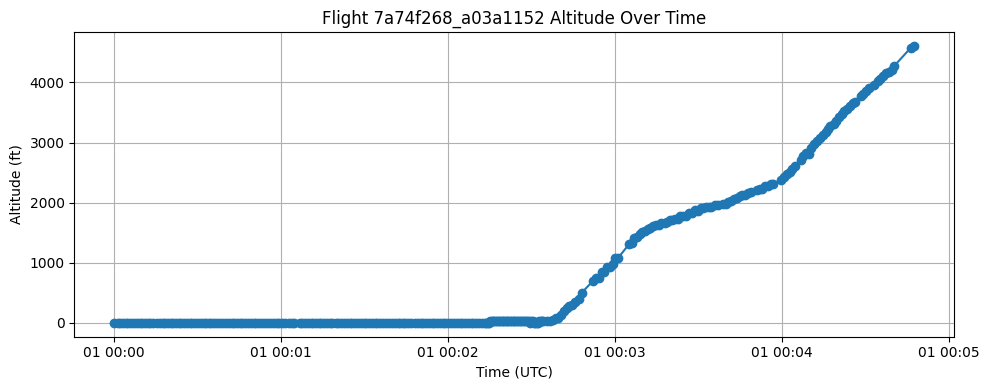

In [10]:
plt.figure(figsize=(10, 4))
plt.plot(flight_df['dt'], flight_df['altitude'], marker='o', linestyle='-')
plt.title(f"Flight {sample_flight_id} Altitude Over Time")
plt.xlabel("Time (UTC)")
plt.ylabel("Altitude (ft)")
plt.grid(True)
plt.tight_layout()
plt.show()

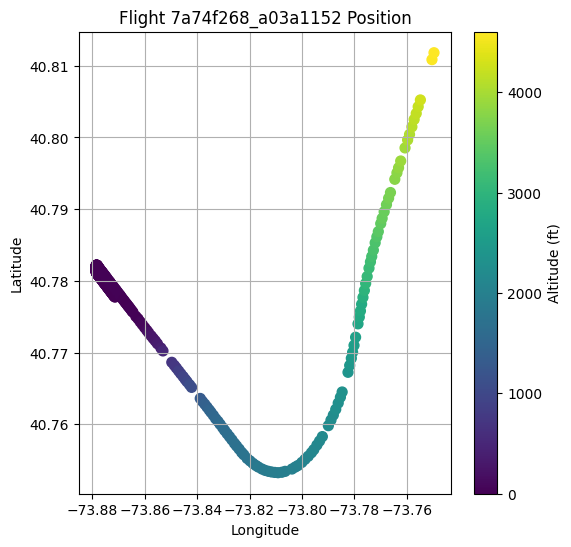

In [11]:
plt.figure(figsize=(6, 6))
plt.scatter(flight_df['longitude'], flight_df['latitude'],
            c=flight_df['altitude'], cmap='viridis', s=50)
plt.colorbar(label='Altitude (ft)')
plt.title(f"Flight {sample_flight_id} Position")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

Folium

In [12]:
# For a more visually pleasing geospatial visualization, we can create a Folium map:
mid_lat = flight_df['latitude'].mean()
mid_lon = flight_df['longitude'].mean()

m = folium.Map(location=[mid_lat, mid_lon], zoom_start=12)

# Add flight track as a line
coords = list(zip(flight_df['latitude'], flight_df['longitude']))
folium.PolyLine(coords, color='blue', weight=3, opacity=0.7).add_to(m)

# Add markers for start & end
start_point = coords[0]
end_point = coords[-1]
folium.Marker(start_point, popup="Start").add_to(m)
folium.Marker(end_point, popup="End").add_to(m)

In [13]:
m

In [14]:
# Get min, max, and average altitude for this flight
min_alt = flight_df['altitude'].min()
max_alt = flight_df['altitude'].max()
mean_alt = flight_df['altitude'].mean()

print(f"Basic Altitude Stats for Flight {sample_flight_id}:")
print(f"  Minimum Altitude: {min_alt:.2f} ft")
print(f"  Maximum Altitude: {max_alt:.2f} ft")
print(f"  Average Altitude: {mean_alt:.2f} ft\n")

Basic Altitude Stats for Flight 7a74f268_a03a1152:
  Minimum Altitude: 0.00 ft
  Maximum Altitude: 4604.39 ft
  Average Altitude: 855.97 ft



In [15]:
nearby_icao_codes = flight_df['icao_code'].unique()
print(f"Flight {sample_flight_id} was associated with these ICAO codes: {nearby_icao_codes}\n")

Flight 7a74f268_a03a1152 was associated with these ICAO codes: ['E75L']



In [16]:
merged_example = pd.merge(
    flight_df,
    airport_df,
    on="icao_code",
    how="left",  # so we don't lose flight data that doesn't match
    suffixes=("_pos", "_airport")
)
print("Merged flight data with airport info (sample rows):")
print(merged_example[['dt','identifier','latitude_pos','longitude_pos','name']].head())


Merged flight data with airport info (sample rows):
                       dt identifier  latitude_pos  longitude_pos name
0 2024-07-01 00:00:00.047   a03a1152     40.777731     -73.871319  NaN
1 2024-07-01 00:00:01.203   a03a1152     40.777795     -73.871448  NaN
2 2024-07-01 00:00:02.242   a03a1152     40.777838     -73.871555  NaN
3 2024-07-01 00:00:03.148   a03a1152     40.777881     -73.871641  NaN
4 2024-07-01 00:00:04.102   a03a1152     40.777924     -73.871748  NaN


Analysis: I want to know, although presumably all of these sample flights landed safely, can we rank the safest to least safe flights in this dataset? On top of that, what factors determine the safest score?

In [25]:
'''
Add some columns to enrich the dataset.
'''
flight_df['altitude_change'] = flight_df['altitude'].diff()
flight_df['time_diff'] = flight_df['dt'].diff().dt.total_seconds()
flight_df['altitude_change_rate'] = flight_df['altitude_change'] / flight_df['time_diff']


In [31]:
'''
Analyze ground speed and check for abnormal low altitude speeds
'''
# Calculate time difference
flight_df['time_diff'] = flight_df['dt'].diff().dt.total_seconds()

# Calculate distance
flight_df['distance_nm'] = flight_df.apply(lambda row: 
    distance((row['latitude'], row['longitude']),
             (flight_df['latitude'].shift().iloc[0], flight_df['longitude'].shift().iloc[0])).nm 
    if not pd.isna(flight_df['latitude'].shift().iloc[0]) else 0, axis=1)

# Calculate speed
flight_df['speed_kts'] = np.where(flight_df['time_diff'] > 0, 
                                  flight_df['distance_nm'] / (flight_df['time_diff'] / 3600), 
                                  0)

# Check for unusually high speeds
high_speed_events = flight_df[flight_df['speed_kts'] > 500]
if not high_speed_events.empty:
    print("Unusually high speed detected:")
    print(high_speed_events[['dt', 'speed_kts', 'altitude']])
else:
    print("No unusually high speeds detected.")

# Print some statistics about the speeds
print("\nSpeed statistics:")
print(flight_df['speed_kts'].describe())

No unusually high speeds detected.

Speed statistics:
count    289.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: speed_kts, dtype: float64


In [39]:
'''
Let's create a safety score function that takes in multiple flight attributes and returns a score
for a flight.
'''

def calculate_safety_components(flight_df):
    # Calculate time difference
    flight_df['time_diff'] = flight_df['dt'].diff().dt.total_seconds()
    
    # Calculate distance
    flight_df['distance_nm'] = flight_df.apply(lambda row: 
        distance((row['latitude'], row['longitude']),
                 (flight_df['latitude'].shift().iloc[0], flight_df['longitude'].shift().iloc[0])).nm 
        if not pd.isna(flight_df['latitude'].shift().iloc[0]) else 0, axis=1)
    
    # Calculate speed
    flight_df['speed_kts'] = np.where(flight_df['time_diff'] > 0, 
                                      flight_df['distance_nm'] / (flight_df['time_diff'] / 3600), 
                                      0)
    
    # Calculate vertical speed (feet per minute)
    flight_df['vertical_speed_fpm'] = flight_df['altitude'].diff() / (flight_df['time_diff'] / 60)
    
    # Safety score components
    high_speed_score = len(flight_df[flight_df['speed_kts'] > 500])
    low_altitude_score = len(flight_df[(flight_df['altitude'] < 1000) & (flight_df['speed_kts'] > 250)])
    high_vertical_speed_score = len(flight_df[abs(flight_df['vertical_speed_fpm']) > 3000])
    
    # Overall safety score
    safety_score = high_speed_score + low_altitude_score + high_vertical_speed_score
    
    return high_speed_score, low_altitude_score, high_vertical_speed_score, safety_score


In [40]:
# Create a list to store results
results = []

# Iterate through each unique flight
for flight_id in position_df['unique_flight_id'].unique():
    flight_df = position_df[position_df['unique_flight_id'] == flight_id].copy()
    
    if len(flight_df) > 1:  # Ensure we have at least two data points
        high_speed, low_altitude, high_vertical_speed, safety_score = calculate_safety_components(flight_df)
        
        results.append({
            'flight_id': flight_id,
            'high_speed_events': high_speed,
            'low_altitude_high_speed_events': low_altitude,
            'high_vertical_speed_events': high_vertical_speed,
            'safety_score': safety_score,
            'data_points': len(flight_df),
            'start_time': flight_df['dt'].min(),
            'end_time': flight_df['dt'].max(),
        })

# Create a dataframe from the results
safety_df = pd.DataFrame(results)

Rank the flights by safety score (lower is better)

In [47]:
safety_df['safety_rank'] = safety_df['safety_score'].rank(method='dense')

# Sort by safety rank
safety_df = safety_df.sort_values('safety_rank')

In [48]:
safety_df.head(10)

,flight_id,high_speed_events,low_altitude_high_speed_events,high_vertical_speed_events,safety_score,data_points,start_time,end_time,safety_rank
1501,e8e4c3b1_73124b8d,0,0,0,0,6,2024-07-01 23:59:53.773,2024-07-01 23:59:59.633,1.0
962,6e987745_0bb02128,0,0,0,0,493,2024-07-01 18:00:42.352,2024-07-01 18:18:25.156,1.0
953,5b5011d7_4ff8c985,0,0,0,0,285,2024-07-01 17:53:11.617,2024-07-01 17:58:11.047,1.0
945,592d3230_ddb8755c,0,0,0,0,66,2024-07-01 17:46:36.320,2024-07-01 17:47:42.508,1.0
145,c4a6ecd9_4127f559,0,0,0,0,143,2024-07-01 02:22:51.563,2024-07-01 02:25:17.844,1.0
939,acc93b5f_173d5c03,0,0,0,0,62,2024-07-01 17:44:47.414,2024-07-01 17:45:50.250,1.0
935,62ebfefb_886e9ed0,0,0,0,0,67,2024-07-01 17:42:00.000,2024-07-01 17:43:09.070,1.0
933,70c8cfc8_56ee4ae0,0,0,0,0,84,2024-07-01 17:38:54.203,2024-07-01 17:40:18.172,1.0
922,feab5d30_9a39e50e,0,0,0,0,81,2024-07-01 17:33:47.125,2024-07-01 17:35:10.117,1.0
914,5b85ad55_49b08f82,0,0,0,0,82,2024-07-01 17:28:13.688,2024-07-01 17:29:38.359,1.0


In [49]:
# Display the top 10 safest and top 10 least safe flights
print("Top 10 Safest Flights:")
safety_df.head(10)

Top 10 Safest Flights:


,flight_id,high_speed_events,low_altitude_high_speed_events,high_vertical_speed_events,safety_score,data_points,start_time,end_time,safety_rank
1501,e8e4c3b1_73124b8d,0,0,0,0,6,2024-07-01 23:59:53.773,2024-07-01 23:59:59.633,1.0
962,6e987745_0bb02128,0,0,0,0,493,2024-07-01 18:00:42.352,2024-07-01 18:18:25.156,1.0
953,5b5011d7_4ff8c985,0,0,0,0,285,2024-07-01 17:53:11.617,2024-07-01 17:58:11.047,1.0
945,592d3230_ddb8755c,0,0,0,0,66,2024-07-01 17:46:36.320,2024-07-01 17:47:42.508,1.0
145,c4a6ecd9_4127f559,0,0,0,0,143,2024-07-01 02:22:51.563,2024-07-01 02:25:17.844,1.0
939,acc93b5f_173d5c03,0,0,0,0,62,2024-07-01 17:44:47.414,2024-07-01 17:45:50.250,1.0
935,62ebfefb_886e9ed0,0,0,0,0,67,2024-07-01 17:42:00.000,2024-07-01 17:43:09.070,1.0
933,70c8cfc8_56ee4ae0,0,0,0,0,84,2024-07-01 17:38:54.203,2024-07-01 17:40:18.172,1.0
922,feab5d30_9a39e50e,0,0,0,0,81,2024-07-01 17:33:47.125,2024-07-01 17:35:10.117,1.0
914,5b85ad55_49b08f82,0,0,0,0,82,2024-07-01 17:28:13.688,2024-07-01 17:29:38.359,1.0


In [50]:
print("\nTop 10 Least Safe Flights:")
safety_df.tail(10)


Top 10 Least Safe Flights:


,flight_id,high_speed_events,low_altitude_high_speed_events,high_vertical_speed_events,safety_score,data_points,start_time,end_time,safety_rank
516,720d7d3a_f5e55a92,0,0,117,117,2242,2024-07-01 12:36:38.273,2024-07-01 22:36:05.320,93.0
32,eef094ef_aeff03fe,0,0,117,117,2324,2024-07-01 00:30:59.813,2024-07-01 23:14:17.148,93.0
324,50bb2b4e_3c86b777,0,0,121,121,440,2024-07-01 05:47:18.500,2024-07-01 05:52:54.477,94.0
1481,598e0c5b_888e49ea,0,0,128,128,703,2024-07-01 23:44:10.398,2024-07-01 23:50:16.594,95.0
579,2ca269a1_c92340d4,0,0,149,149,2631,2024-07-01 13:17:54.555,2024-07-01 21:37:48.305,96.0
73,39db7226_ac56f5be,0,0,154,154,802,2024-07-01 01:15:10.844,2024-07-01 01:29:10.406,97.0
596,67606c03_1562b97c,0,0,158,158,6030,2024-07-01 13:27:33.508,2024-07-01 21:52:36.289,98.0
506,b07d6dc3_ef1e208b,0,0,169,169,3241,2024-07-01 12:32:07.766,2024-07-01 21:15:52.422,99.0
572,0d173aa5_76ac8c29,0,0,182,182,5819,2024-07-01 13:13:33.375,2024-07-01 21:55:59.516,100.0
51,3fa78ba9_88de00c7,0,0,219,219,871,2024-07-01 00:56:20.156,2024-07-01 01:14:03.297,101.0


In [41]:
# Analyze the importance of each component
print("\nCorrelation between components and overall safety score:")
correlation = safety_df[['high_speed_events', 'low_altitude_high_speed_events', 
                         'high_vertical_speed_events', 'safety_score']].corr()['safety_score']
print(correlation)


Correlation between components and overall safety score:
high_speed_events                 NaN
low_altitude_high_speed_events    NaN
high_vertical_speed_events        1.0
safety_score                      1.0
Name: safety_score, dtype: float64


In [42]:
# Calculate the average contribution of each component
total_events = safety_df[['high_speed_events', 'low_altitude_high_speed_events', 
                          'high_vertical_speed_events']].sum().sum()
component_contribution = safety_df[['high_speed_events', 'low_altitude_high_speed_events', 
                                    'high_vertical_speed_events']].sum() / total_events * 100

print("\nAverage contribution of each component to the safety score:")
print(component_contribution)


Average contribution of each component to the safety score:
high_speed_events                   0.0
low_altitude_high_speed_events      0.0
high_vertical_speed_events        100.0
dtype: float64


It's difficult to quickly determine analytically what the correlation is between the components and the overall safety score, so let's visually observe the least safe flight in this dataset to see if we can potentially visualize what occurred on that flight.

In [51]:
unsafest_flight_id = '3fa78ba9_88de00c7'
flight_df = position_df[position_df['unique_flight_id'] == unsafest_flight_id].copy()
flight_df.head(10)

,dt,mode_s,identifier,latitude,longitude,altitude,icao_code,unique_flight_id
17943,2024-07-01 00:56:20.156,3fa78ba9,88de00c7,40.770929,-73.861685,0.0,CRJ9,3fa78ba9_88de00c7
17952,2024-07-01 00:56:21.203,3fa78ba9,88de00c7,40.770929,-73.861663,0.0,CRJ9,3fa78ba9_88de00c7
17962,2024-07-01 00:56:22.508,3fa78ba9,88de00c7,40.770950,-73.861663,0.0,CRJ9,3fa78ba9_88de00c7
17980,2024-07-01 00:56:25.336,3fa78ba9,88de00c7,40.770993,-73.861620,0.0,CRJ9,3fa78ba9_88de00c7
17986,2024-07-01 00:56:26.438,3fa78ba9,88de00c7,40.770993,-73.861599,0.0,CRJ9,3fa78ba9_88de00c7
18031,2024-07-01 00:56:34.359,3fa78ba9,88de00c7,40.771058,-73.861513,0.0,CRJ9,3fa78ba9_88de00c7
18039,2024-07-01 00:56:35.492,3fa78ba9,88de00c7,40.771058,-73.861492,0.0,CRJ9,3fa78ba9_88de00c7
18056,2024-07-01 00:56:38.219,3fa78ba9,88de00c7,40.771079,-73.861449,0.0,CRJ9,3fa78ba9_88de00c7
18110,2024-07-01 00:56:47.633,3fa78ba9,88de00c7,40.771122,-73.861277,0.0,CRJ9,3fa78ba9_88de00c7
18118,2024-07-01 00:56:49.148,3fa78ba9,88de00c7,40.771122,-73.861256,0.0,CRJ9,3fa78ba9_88de00c7


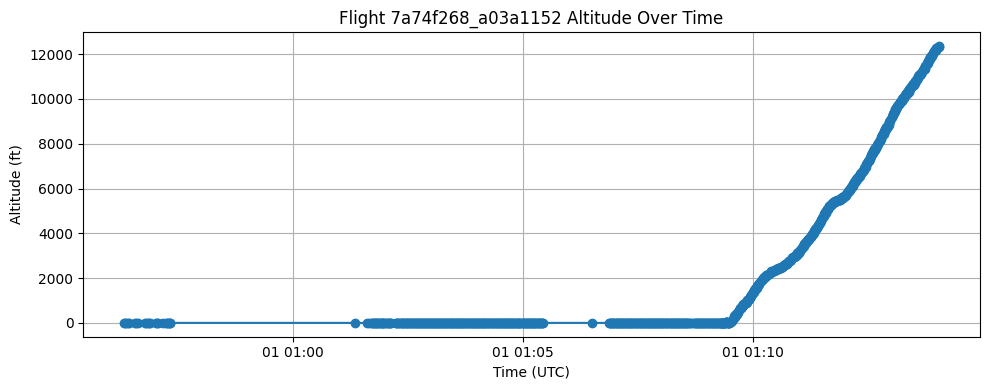

In [52]:
plt.figure(figsize=(10, 4))
plt.plot(flight_df['dt'], flight_df['altitude'], marker='o', linestyle='-')
plt.title(f"Flight {unsafest_flight_id} Altitude Over Time")
plt.xlabel("Time (UTC)")
plt.ylabel("Altitude (ft)")
plt.grid(True)
plt.tight_layout()
plt.show()

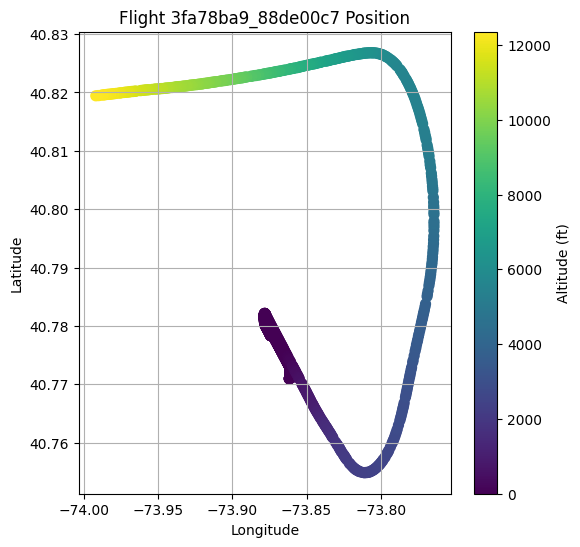

In [53]:
plt.figure(figsize=(6, 6))
plt.scatter(flight_df['longitude'], flight_df['latitude'],
            c=flight_df['altitude'], cmap='viridis', s=50)
plt.colorbar(label='Altitude (ft)')
plt.title(f"Flight {unsafest_flight_id} Position")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

In [54]:
# Recreate folium map
mid_lat = flight_df['latitude'].mean()
mid_lon = flight_df['longitude'].mean()

m = folium.Map(location=[mid_lat, mid_lon], zoom_start=12)

# Add flight track as a line
coords = list(zip(flight_df['latitude'], flight_df['longitude']))
folium.PolyLine(coords, color='blue', weight=3, opacity=0.7).add_to(m)

# Add markers for start & end
start_point = coords[0]
end_point = coords[-1]
folium.Marker(start_point, popup="Start").add_to(m)
folium.Marker(end_point, popup="End").add_to(m)

In [55]:
m

It's hard to determine exactly what happened here, but we can make a couple of quick guesses now that we can visualize the data.

1. It appears that there was a ground delay of several minutes based on unsafe fig. 1. We can tell this by the lack of altitude change over time.
2. Unsafe plots figures 1 and 2 also show a steep altitude change over time. This really quick ascent is probably not normal compared to the rest of the dataset, given its outlier safety score.
3. Figures 2 and 3 also show a very hard 180 degree turn from take-off. Again, common sense would tell you that most flights beginning their flight with a steep, rapidly ascending 180 degree bend would probably be unsafe.
4. Given that we have a map in figure 3, we also know that pilot and crew may have needed to ascend rapidly to get out of Manhatten airspace to avoid looking like a terrorist risk as well.

Conclusion: While a bit of speculation, one could imagine that a flight crew that was delayed for a significant period of time that knows it needs to ascend the other direction quickly might make a snap judgement and ascend at an unsafe rate. Already, you could make a few recommendations to stakeholders.

1. Avoid steep high altitude ascends. While this may display exceptional skill of the pilots, this maneuver stands out in our data as exceptionally dangerous for all involved.
2. Ease anxieties along the runway. While we cannot know for certain what was going through the mind of the pilots with this data alone, the wait time along the runway may have contributed to the flight crew wanting to make up for lost time in the air. Again, an unsafe maneuver to make up a few minutes would not be worth it.
3. Given the hard banking, one wonders if the maneuver could have been widened over a longer distance to increase the safety of those involved.

That is quite frankly all the time I have to conduct this analysis. If given more time I would:
* Delve more into building some more feature engineering and correlations between variables. If given enough data, I may even conduct a PCA analysis.
* Make the matplotlib plots more interactive, with better timestamp handling.
* Add more interactivity to the dataframes and allow filtering and sorting.
* Try to visualize if the planes were overlapping in the take offs and landings. Was our unsafest flight an independent instance, or was the flight trying to avoid another? Something worth exploring.